In [1]:
%matplotlib inline
import slug
import os
import glob
import h5py

import numpy as np

import matplotlib.pyplot as plt

from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column


from IPython.display import clear_output

In [2]:
os.chdir('/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/MockTest/easy/HDF5/')
files = glob.glob('*')
os.chdir('..')

In [3]:
files

['MockGalaxy-002.h5',
 'MockGalaxy-003.h5',
 'MockGalaxy-004.h5',
 'MockGalaxy-000.h5',
 'MockGalaxy-001.h5']

### 1-D profile of mock image

# Run in-batch

('At redshift', 0.2, ', 1 arcsec =', 3.2996519002413693, 'kpc')
# Detect 119 objects
# Detect 197 objects
# Mean Sky / RMS Sky =    0.00182 /    0.05667


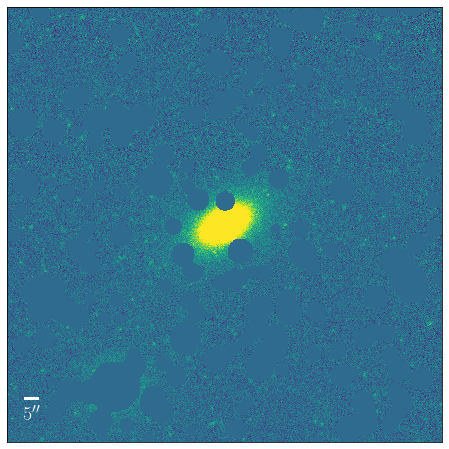

./Masks/s18a_bkg001_n4_msk.fits -> temp_WLR1K.fits.pl
./Masks/s18a_bkg001_n4_msk.fits -> temp_WLR1K.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  500 500
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./Images/s18a_bkg001_n4_img.fits
###      Input Image   : temp_WLR1K.fits
###      Output Binary : ./Images/s18a_bkg001_n4_img_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     In

In [35]:
for obj in files[2:]:
    clear_output()
    index = obj.lstrip('MockGalaxy-').rstrip('.h5')
    sersic_index = 4
    prefix = 's18a_bkg' + index + '_n' + str(sersic_index)
    
    f = h5py.File('./HDF5/MockGalaxy-'+ index +'.h5')

    img = f['MockImage']['n' + str(sersic_index)].value
    w = wcs.WCS(f['background']['image_header'].value)
    g4 = f.create_group('Mask')
    g5 = f.create_group('MaskedImage')

    # phys_size
    redshift = 0.2
    phys_size = slug.phys_size(redshift)
    # extract_obj
    data = img
    objects, segmap = slug.extract_obj(
        data,
        b=30,
        f=5,
        sigma=5,
        pixel_scale=slug.HSC_pixel_scale,
        deblend_cont=0.1,
        deblend_nthresh=20,
        show_fig=False)
    # make mask
    seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
    objects, segmap = slug.extract_obj(data, b=30, f=5, sigma=3, pixel_scale=slug.HSC_pixel_scale,
        deblend_cont=0.1, deblend_nthresh=20, show_fig=False)
    # make mask
    seg_mask_2 = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
    seg_mask = seg_mask + seg_mask_2

    # evaluate_sky
    bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)

    f['info'][5] = 'global bkg', bkg_global.globalback
    f['info'][6] = 'global rms', bkg_global.globalrms

    g4.create_dataset('n' + str(sersic_index), data=seg_mask)
    g5.create_dataset('n' + str(sersic_index), data=data*(~seg_mask))

    # Save image and mask
    if not os.path.isdir('Images'):
        os.mkdir('Images')
    if not os.path.isdir('Masks'):
        os.mkdir('Masks')
    img_fits = './Images/' + prefix + '_img.fits'
    msk_fits = './Masks/' + prefix + '_msk.fits'
    io.save_to_fits(data, img_fits, wcs=w)
    io.save_to_fits(seg_mask.astype('uint8'), msk_fits, wcs=w)

    display_single(data*(~seg_mask))
    plt.show(block=False)
    # Run ELLIPSE
    iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
    ell_free, ell_fix = slug.run_SBP(
        img_fits,
        msk_fits,
        slug.HSC_pixel_scale,
        phys_size,
        iraf_path,
        step=0.1,
        n_clip=3,
        low_clip=3.0,
        upp_clip=2.5,
        outPre=prefix)
    f['info'][7] = 'mean_e', ell_fix['ell'][10]
    f['info'][8] = 'mean_pa', ell_fix['pa'][10]
    f.create_dataset('ell_fix', data=ell_fix)
    f.create_dataset('ell_free', data=ell_free)

    # Write the profile of model galaxy into the HDF5 file
    ell_model_fix = Table.read('./Data/model_n4-ellip-3.csv', format='csv')
    f.create_dataset('ell_model', data=ell_model_fix)
    f.close()

In [39]:
def print_attrs(name, obj):
    print name
    for key, val in obj.attrs.iteritems():
        print "    %s: %s" % (key, val)
f = h5py.File('./HDF5/MockGalaxy-004.h5', 'r')
f.visititems(print_attrs)
print(f['info'].value)
f.close()

Mask
Mask/n4
MaskedImage
MaskedImage/n4
MockImage
MockImage/n4
MockImage/n6
ModelImage
ModelImage/n4
ModelImage/n6
background
background/image
background/image_header
background/primary_header
background/variance
background/variance_header
ell_fix
ell_free
ell_model
info
[['edition' 's18a']
 ['ra' '201.219403']
 ['dec' '-2.0988224']
 ['size (pix)' '1000']
 ['global bkg' '0.00766175']
 ['global rms' '0.11051274']
 ['mean_e' '0.39']
 ['mean_pa' '-59.78']
 ['' '']
 ['' '']]


## Subtract the mean value of nearby sky objects

In [51]:
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
sky_cat = Table.read('/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/s18a_wide_skyobject_flux.fits', format='fits')

In [64]:
f = h5py.File('./HDF5/MockGalaxy-000.h5', 'r')
ra, dec = float(f['info'][1,1]), float(f['info'][2,1])

bkg_pos = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
catalog = SkyCoord(ra=sky_cat['i_ra']*u.degree, dec=sky_cat['i_dec']*u.degree)
obj_inx = np.where(catalog.separation(bkg_pos)<1*u.arcmin)[0]

print('sky objects number:', len(obj_inx))
print (sky_cat[obj_inx]['r_apertureflux_40_flux']*1.7378e30/(np.pi*12**2)).mean()
print (sky_cat[obj_inx]['r_apertureflux_57_flux']*1.7378e30/(np.pi*17**2)).mean()

off_set = (sky_cat[obj_inx]['r_apertureflux_57_flux']*1.7378e30/(np.pi*17**2)).mean()

('sky objects number:', 4)
0.005173962701849186
0.0063213388347678565


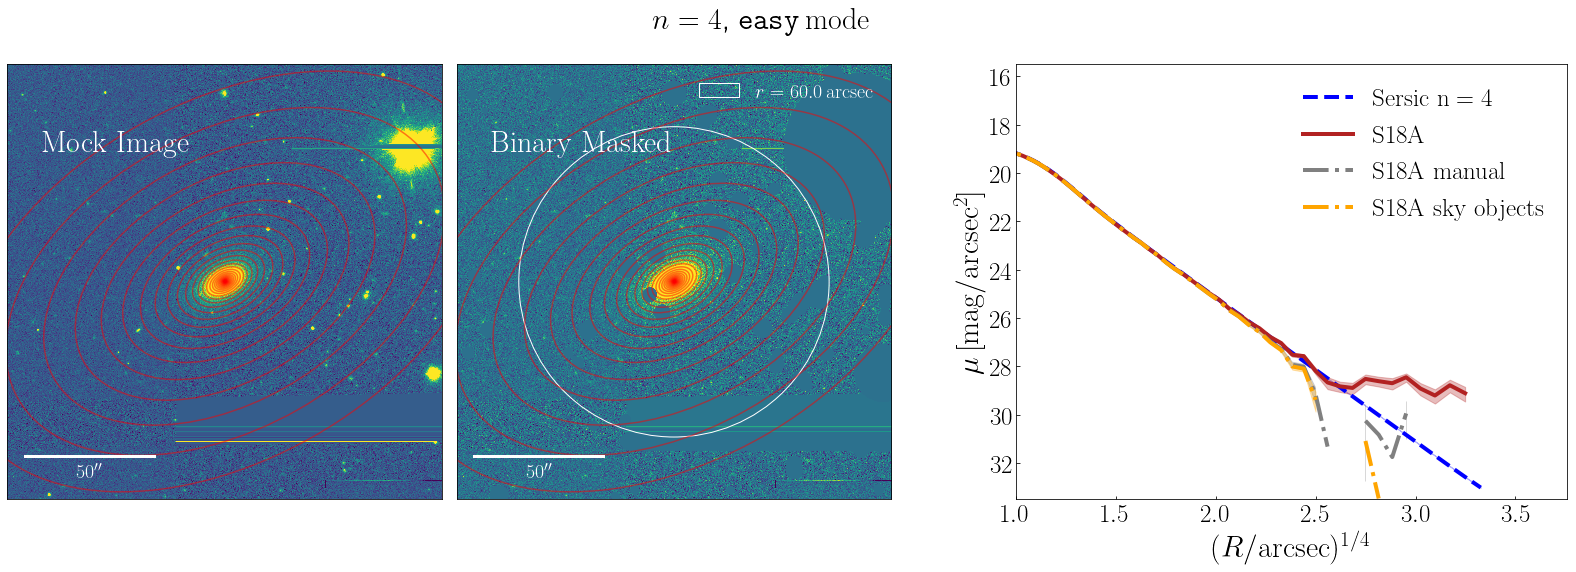

In [65]:
mock_s18a_ellipse_fix = f['ell_fix'].value
model_ellipse_fix = f['ell_model'].value
img = f['MockImage']['n4'].value
masked_img = f['MaskedImage']['n4'].value

fig = plt.figure(figsize=(28, 8))
grid = plt.GridSpec(1, 14, wspace=0.1, hspace=0.1)

ax1 = fig.add_subplot(grid[0, 0:4])
ax1 = slug.display_isophote(
    img,
    mock_s18a_ellipse_fix,
    slug.HSC_pixel_scale,
    text='Mock\ Image',
    ax=ax1)

ax2 = fig.add_subplot(grid[0, 4:8])
ax2 = slug.display_isophote(
    masked_img,
    mock_s18a_ellipse_fix,
    slug.HSC_pixel_scale,
    text='Binary\ Masked',
    ax=ax2,
    circle=60)

ax3 = fig.add_subplot(grid[0, 9:])
ax3.tick_params(direction='in')

slug.SBP_single(
    model_ellipse_fix,
    0.2,
    slug.HSC_pixel_scale,
    slug.HSC_zeropoint,
    label='Sersic\ n=4',
    physical_unit=False,
    ax=ax3,
    linecolor='blue',
    linestyle='--',
    x_min=0,
    x_max=3.7)

slug.SBP_single(mock_s18a_ellipse_fix, 0.2, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3,
    physical_unit=False, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='firebrick',
    linestyle='-', label="S18A")
slug.SBP_single(
    mock_s18a_ellipse_fix, 0.2, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3, offset=-float(f['info'].value[5][1]),
    physical_unit=False, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='gray',
    linestyle='-.', label="S18A\ manual")
slug.SBP_single(
    mock_s18a_ellipse_fix, 0.2, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3, offset=-off_set,
    physical_unit=False, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='orange',
    linestyle='-.', label="S18A\ sky\ objects")

plt.ylim(15.5, 33.5)
#plt.vlines((100 * 0.168)**0.25, 15.5, 32.5, linestyle='-.', label='60 arcsec')
ax3.invert_yaxis()
plt.subplots_adjust(hspace=0.)
plt.suptitle(r'$n=4$, \texttt{easy}$\mathrm{\,mode}$', fontsize=30)

f.close()
#plt.savefig('./Figures/' + prefix + '.png', dpi=100, bbox_inches='tight')